# Filtering large-scale volumes

This notebook describes how to **process large-scale volumes**, addressing how to

- **Avoid running out of memory**
- **Interactively select, apply, and optimize parameters on a region of interest**
- **Process the volume in parallel**

There are three sections addressing,

1. How to
    - Pre-compute the chunked, multiscale volumetric pyramid
    - Interactively select a region of interest (ROI) and data scale
    - Interactively apply the filter, inspect the results, and optimize parameters
    - Apply the filter over the entire, multiscale volume
2. Apply algorithms categories that require
    1. Only the pixel value
    2. A known load domain around a pixel
    3. An extended information context
3. Examples with a few common filters



In [1]:
import itk
import pooch
from ngff_zarr import ngff_image_to_itk_image, to_ngff_zarr, itk_image_to_ngff_image, to_multiscales, to_ngff_zarr, Methods
from itkwidgets import view
import zarr
from rich import print

## Pre-compute the chunked, multiscale volumetric pyramid

Internally, `itkwidgets` will generate an in-memory chunked, multiscale [OME-Zarr](https://ngff.openmicroscopy.org/latest/) for interactive visualization of the volume.

When working with large datasets, the compressed, chunked, multiscale representation can be pre-generated without loading the volume into memory. For more information, see [ngff-zarr](https://ngff-zarr.readthedocs.io/en/latest/). 

In [6]:
itk_image = itk.imread("./turkey_vulture_skull_small.tif")
ngff_image = itk_image_to_ngff_image(itk_image)

For `Methods.ITK_GAUSSIAN` support,

```sh
pip install "ngff-zarr[itk]"
```

To add GPU acceleration,

```sh
pip install itk-vkfft
```

In [7]:
multiscales = to_multiscales(ngff_image, method=Methods.ITK_GAUSSIAN)
zarr_store = zarr.DirectoryStore("./turkey_vulture_skull_small.zarr", dimension_separator="/")
to_ngff_zarr(zarr_store, multiscales)


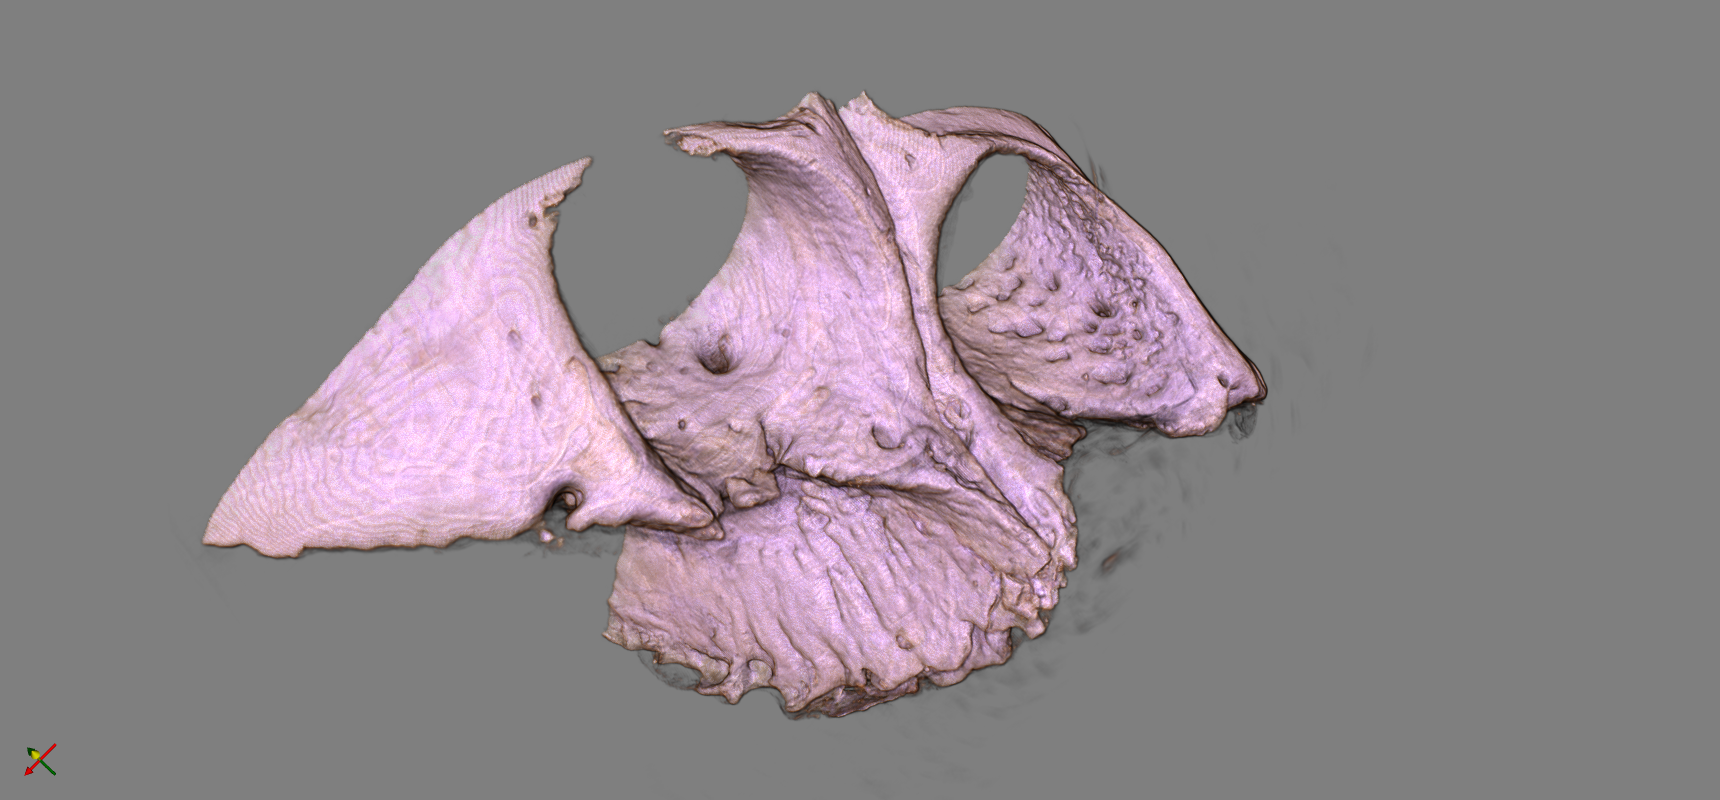
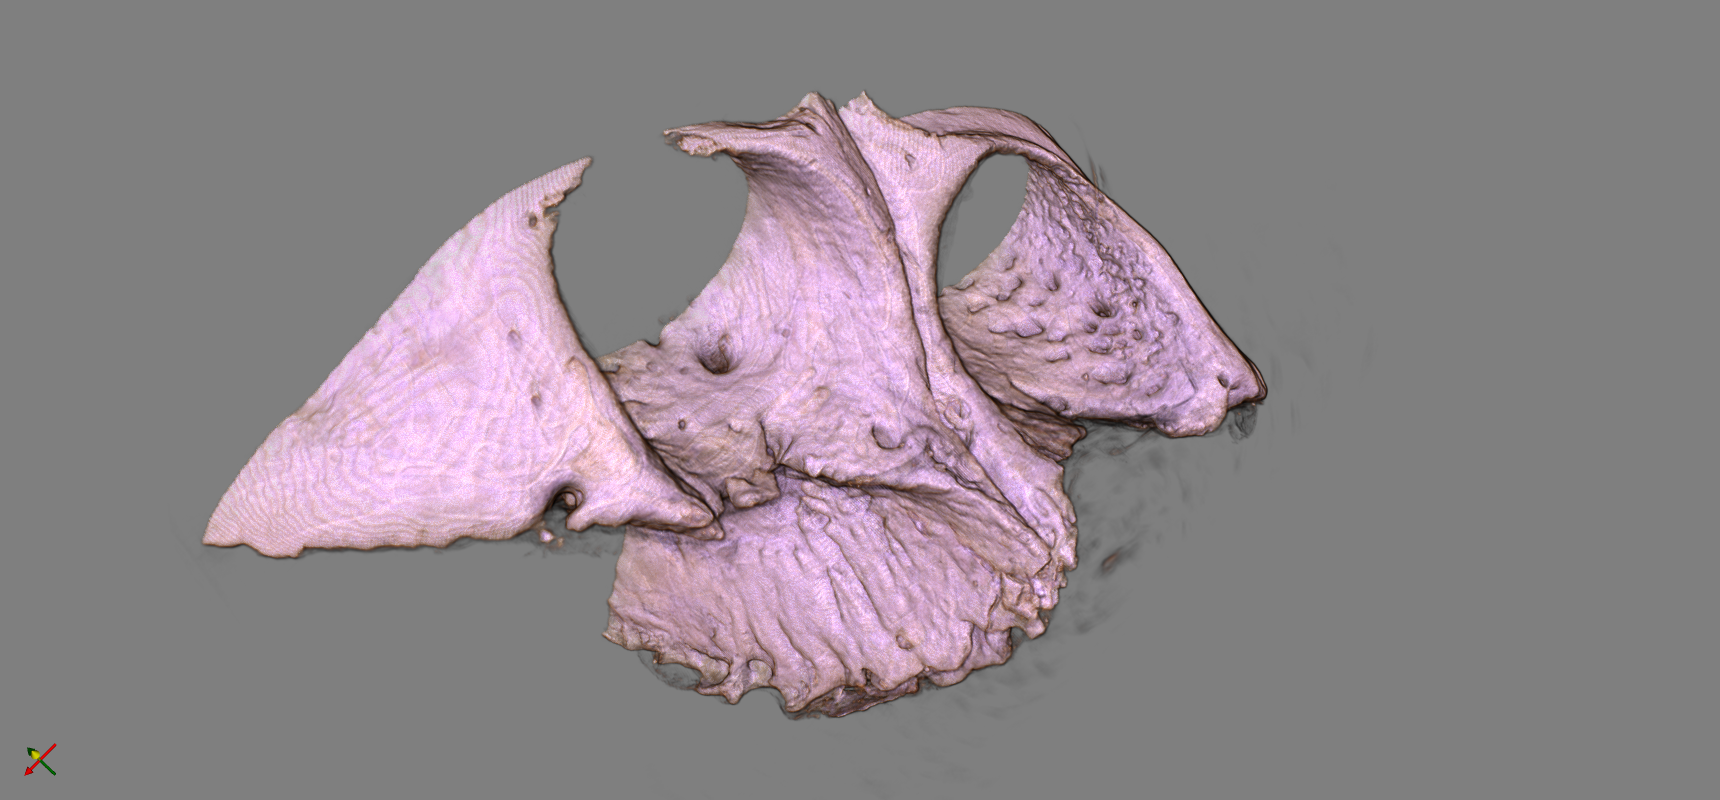

<IPython.core.display.Javascript object>

In [3]:
image = zarr.open(zarr_store)

viewer = view(image)

## Interactively select a region of interest (ROI) and data scale

#### There will be one or more resolution scales available depending on the size of the data. The lower the scale the higher the resolution, with zero being the highest resolution.

In [5]:
# Find the scale that we currently have loaded
loaded_scale = viewer.get_current_scale()

In [6]:
loaded_scale

0

#### By default the information for the current scale is returned when requesting the ROI slices. You can also pass a value in to explicitly request a scale.

In [7]:
# Request the slice information for the ROI
default_roi_slices = viewer.get_roi_slice()
roi_slices = viewer.get_roi_slice(loaded_scale)

#### The results should match!
#### *Note*: The data is streamed in in chunks and the current resolution will improve as each scale becomes available. If you find that the slices do not match check the currently loaded scale (either programmatically or with the UI) - it may have improved since you last checked!

In [8]:
# The results should match
print(f'Slices for loaded scale:       {roi_slices}')
print(f'Slices with default parameter: {default_roi_slices}')

Slices for loaded scale:       (slice(0, 250, None), slice(0, 350, None), slice(123, 168, None))

Slices with default parameter: (slice(0, 250, None), slice(0, 350, None), slice(123, 168, None))

#### The ROI region will return the physical, world coordinates for the selection

In [9]:
# Get the selected region for the current level
roi_region = viewer.get_roi_region()

In [10]:
print(roi_region)

[
    {'x': 27.01691884841781, 'y': -6.971699953079224, 'z': -6.971699953079224},
    {'x': 38.634510570526935, 'y': 88.71824049949645, 'z': 61.378257513046265}
]

In [11]:
# get_roi_image will return an ngff image for the currently selected image
# optionally a name can also be passed in to select a specific image if more than one image or label is loaded
roi_image = viewer.get_roi_image(loaded_scale)

In [12]:
print(roi_image)

NgffImage(
    data=dask.array<rechunk-merge, shape=(250, 350, 45), dtype=int16, chunksize=(128, 128, 45), 
chunktype=numpy.ndarray>,
    dims=['z', 'y', 'x'],
    scale={'z': 0.2734, 'y': 0.2734, 'x': 0.2734},
    translation={'x': 27.01691884841781, 'y': -6.971699953079224, 'z': -6.971699953079224},
    name='Image',
    axes_units={'z': None, 'y': None, 'x': None},
    computed_callbacks=[]
)

In [13]:
# Optionally we can also grab the ngff images for all scales
roi_multiscales = viewer.get_roi_multiscale()

In [14]:
print(roi_multiscales)

Multiscales(
    images=[
        NgffImage(
            data=dask.array<rechunk-merge, shape=(250, 350, 45), dtype=int16, chunksize=(128, 128, 45), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 0.2734, 'y': 0.2734, 'x': 0.2734},
            translation={'x': 27.01691884841781, 'y': -6.971699953079224, 'z': -6.971699953079224},
            name='Image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        ),
        NgffImage(
            data=dask.array<getitem, shape=(250, 175, 23), dtype=int16, chunksize=(128, 128, 23), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 0.2734, 'y': 0.5468, 'x': 0.5468},
            translation={'x': 27.01691884841781, 'y': -6.971699953079224, 'z': -6.971699953079224},
            name='Image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        )
    ],
    metadata=Metadata(
        axes=[
            Axis(name='z', type='space', unit=None),
            Axis(name='y', type='space', unit=None),
            Axis(name='x', type='space', unit=None)
        ],
        datasets=[
            Dataset(
                path='scale0/image',
                coordinateTransformations=[
                    Scale(scale=[0.2734, 0.2734, 0.2734], type='scale'),
                    Translation(translation=[-6.835, -6.835, -6.835], type='translation')
                ]
            ),
            Dataset(
                path='scale1/image',
                coordinateTransformations=[
                    Scale(scale=[0.2734, 0.5468, 0.5468], type='scale'),
                    Translation(translation=[-6.835, -6.6983, -6.6983], type='translation')
                ]
            )
        ],
        coordinateTransformations=None,
        name='image',
        version='0.4'
    ),
    scale_factors=None,
    method=None,
    chunks=None
)


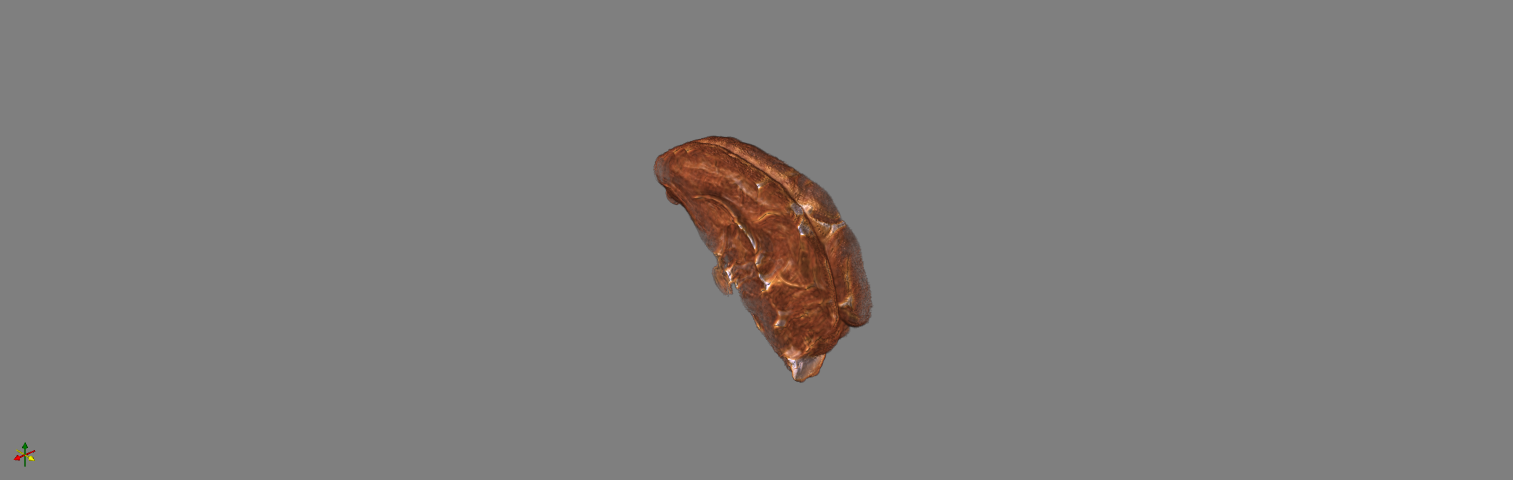
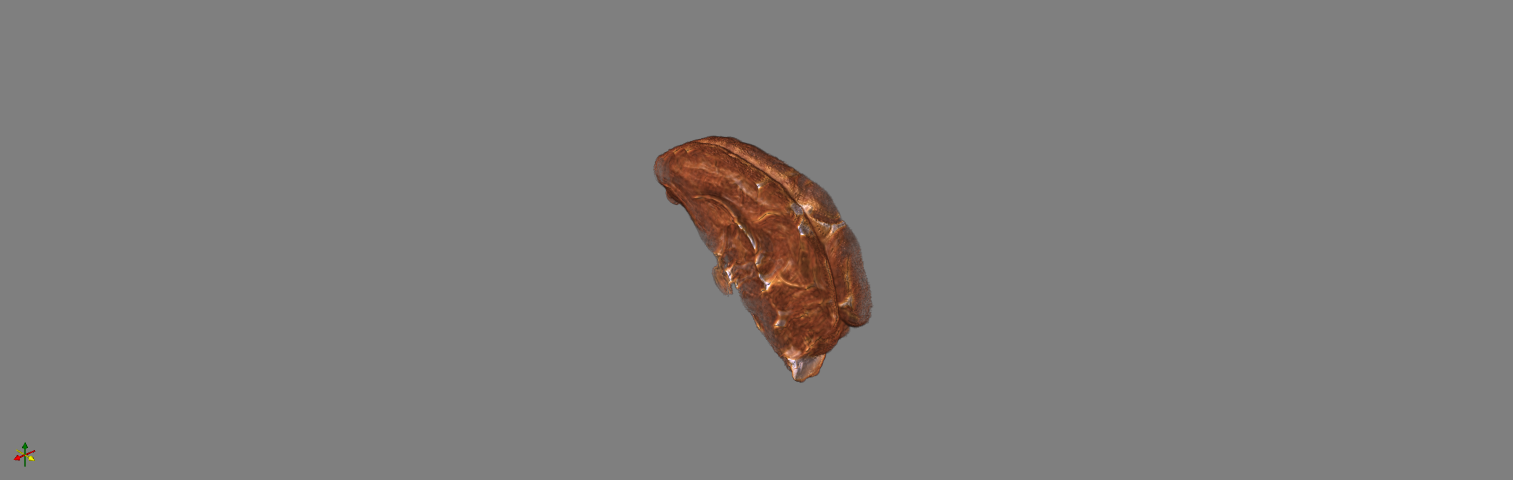

<IPython.core.display.Javascript object>

In [15]:
# Create a new viewer using only the data in the ROI determined above
viewer2 = view(roi_multiscales, rotate=True)

In [16]:
# Save the roi multiscales to an OME-Zarr
to_ngff_zarr('roi.zarr', multiscales=roi_multiscales)

If the goal is just to view or process the ROI, use `get_roi_image`. If the goal is to save the entire roi to disk, use `get_roi_multiscales` followed `to_ngff_zarr`. There is a need to re-align array chunks after roi extraction, which can take some time for the entire multiscale dataset with very large images.

In [17]:
# Get the correpsonding itk.Image
roi_image = ngff_image_to_itk_image(roi_image, wasm=False)

In [19]:
# Run filtering, save to other formats, ...
itk.imwrite(roi_image, 'roi_image.nrrd')

roi_gradient = itk.gradient_magnitude_image_filter(roi_image)
itk.imwrite(roi_gradient, 'roi_gradient.nrrd')

A more detailed, manual example of extracting the `itk.Image` is below.

Extract the region from the original image. 

Use physical units, which are independent of resolutions, slices


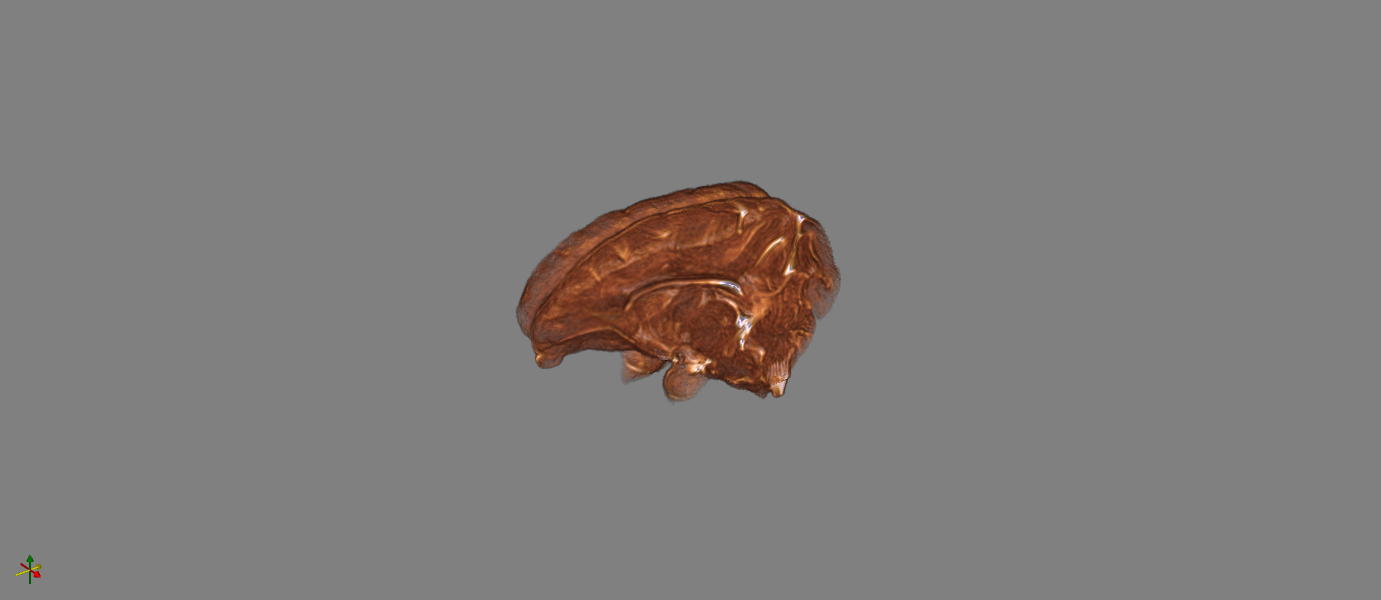
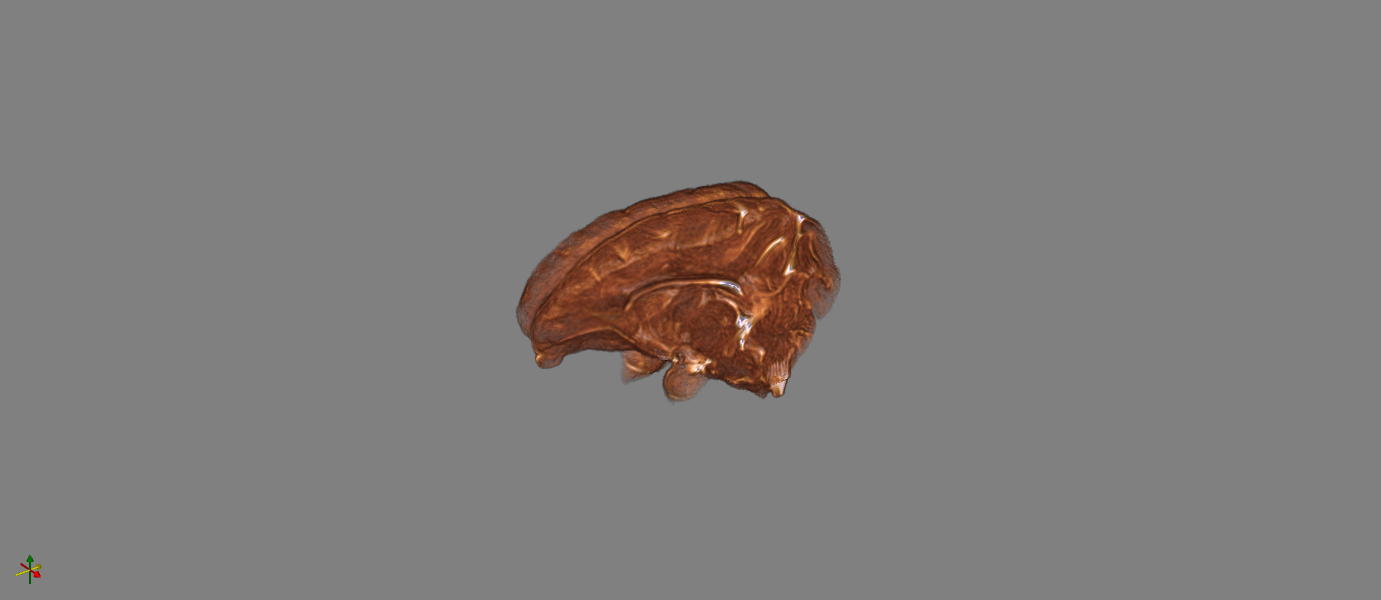

<IPython.core.display.Javascript object>

In [17]:
start_index = image.TransformPhysicalPointToIndex([roi_region[0]['x'], roi_region[0]['y'], roi_region[0]['z']])
size = image.TransformPhysicalPointToIndex([roi_region[1]['x'], roi_region[1]['y'], roi_region[1]['z']]) - start_index
extraction_region = itk.ImageRegion[3](start_index, size)

roi_image = itk.extract_image_filter(image, extraction_region=extraction_region)

viewer3 = view(roi_image, rotate=True)